In [51]:
from grcore.coco.dataset import CocoDataset
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from fridgecore.coco import FridgeDataset
from plotutils import get_params, set_style, to_defaults, tex_escape, save_fig, gen_img_grid, cmap, colors, cmap, title_case
import seaborn as sns
from pathlib import Path
from dhop.dataset import Parts2WholesDataset
from rich.jupyter import print
from rich.pretty import pprint
from common import show_rand_img, check_imgids_in_anns

In [52]:
%pprint

Pretty printing has been turned OFF


In [53]:
supercats = ["person", "car"]
subset="orig"
ttype = "val"

In [54]:
# Import dataset
wholes_path = f"/data/dataset/grmix/{subset}/annotations/{ttype}_wholes.json"
parts_path = Path(f"/data/dataset/grmix/{subset}/annotations/{ttype}_parts.json")
dset = FridgeDataset(CocoDataset(wholes_path))
pdset = None
if parts_path.exists():
    pdset = FridgeDataset(CocoDataset(parts_path))

catdf = pd.DataFrame.from_dict(dset.cats.values())

loading annotations into memory...
Loading json: /data/dataset/grmix/orig/annotations/val_wholes.json
Done 0.02s
creating index...
index created!
loading annotations into memory...
Loading json: /data/dataset/grmix/orig/annotations/val_parts.json
Done 0.03s
creating index...
index created!


## Cats

In [55]:
# Common attributes
print(f"Root path: {dset.root_path}")
print(f"gt path: {dset.gt_path}")
catdf

Root path: /data/dataset/grmix/orig

gt path: /data/dataset/grmix/orig/annotations/val_wholes.json

,id,name,supercategory,is_whole,has_parts
0,1,person,person,True,True
1,2,head,person,False,False
2,3,torso,person,False,False
3,4,larm,person,False,False
4,5,rarm,person,False,False
5,6,lleg,person,False,False
6,7,rleg,person,False,False
7,8,car,car,True,True
8,9,back_bumper,car,False,False
9,10,back_glass,car,False,False


In [56]:
# If categories are equal
if pdset:
    pdf = pd.DataFrame.from_dict(pdset.cats.values())
    print(catdf.equals(pdf))

True

## Anns

In [57]:
# Check same categories in anns
# Some categories could be missing and thus you get false
print(set(dset.get_wholecat_ids()) == set(ann["category_id"] for ann in dset.anns.values()))
if pdset:
    print(set(pdset.get_partcat_ids()) == set(ann["category_id"] for ann in pdset.anns.values()))

True

True

In [58]:
check_imgids_in_anns(dset,pdset)

True

True

In [59]:
occluded = [ann["category_id"] for ann in dset.anns.values() if ann["is_occluded"]]
all = [ann["category_id"] for ann in dset.anns.values()]
allcounter = Counter(all)
oclncounter = Counter(occluded)
print(f"all:{allcounter}")
print(f"ocln:{oclncounter}")
allcounter.subtract(oclncounter)
print(f"non-ocln: {allcounter}")

all:Counter({1: 148, 8: 80})

ocln:Counter()

non-ocln: Counter({1: 148, 8: 80})

In [60]:
# Number of instances on images
for catid, cat in dset.wholecats.items():
    all_annids = Counter()
    imgids = dset.get_imgids([catid])
    for imgid in imgids:
        annids = dset.get_annids([catid], [imgid])
        all_annids.update([len(annids)])
    print(f"{cat['name']}:{all_annids}")

person:Counter({1: 76, 2: 12, 3: 5, 4: 4, 6: 2, 5: 1})

car:Counter({1: 80})

In [61]:
# Check if wholes and parts are mixed
if pdset:
    for catid, cat in pdset.wholecats.items():
        annids = pdset.get_annids([catid])
        print(f"{len(annids)} {cat['name']} wholes in part dataset")

0 person wholes in part dataset

0 car wholes in part dataset

In [62]:
def extract_data(dset, anninfos):
    data = {"catid":[], "cat":[], "supercat":[], "area":[], "ar":[]}
    for anninfo in anninfos:
        if not anninfo.get("is_occluded"):
            data["catid"].append(anninfo['category_id'])
            data["area"].append(anninfo['area'])
            bbox = anninfo["bbox"]
            catinfo = dset.load_catinfos([data["catid"][-1]])[0]
            data["cat"].append(tex_escape(catinfo["name"]))
            data["supercat"].append(catinfo["supercategory"])
            data["ar"].append(bbox[2]/bbox[3])
    return data

# wholes
gt_catids = dset.wholecats.keys()
gt_annids = dset.get_annids(gt_catids)
gt_anns = dset.load_anninfos(gt_annids)
data = extract_data(dset, gt_anns)

# parts
if pdset:
    dt_catids = pdset.partcats.keys()
    dt_annids = pdset.get_annids(dt_catids)
    dt_anns = pdset.load_anninfos(dt_annids)
    dt_data = extract_data(pdset, dt_anns)
    data.update(dt_data)

# To dataframe
df = pd.DataFrame.from_dict(data)
df["selected"] = df["area"].apply(lambda x: x>=100)
df = df.sort_values(["catid"])

/opt/blender/2.83/python/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


<Figure size 1050x648.936 with 0 Axes>

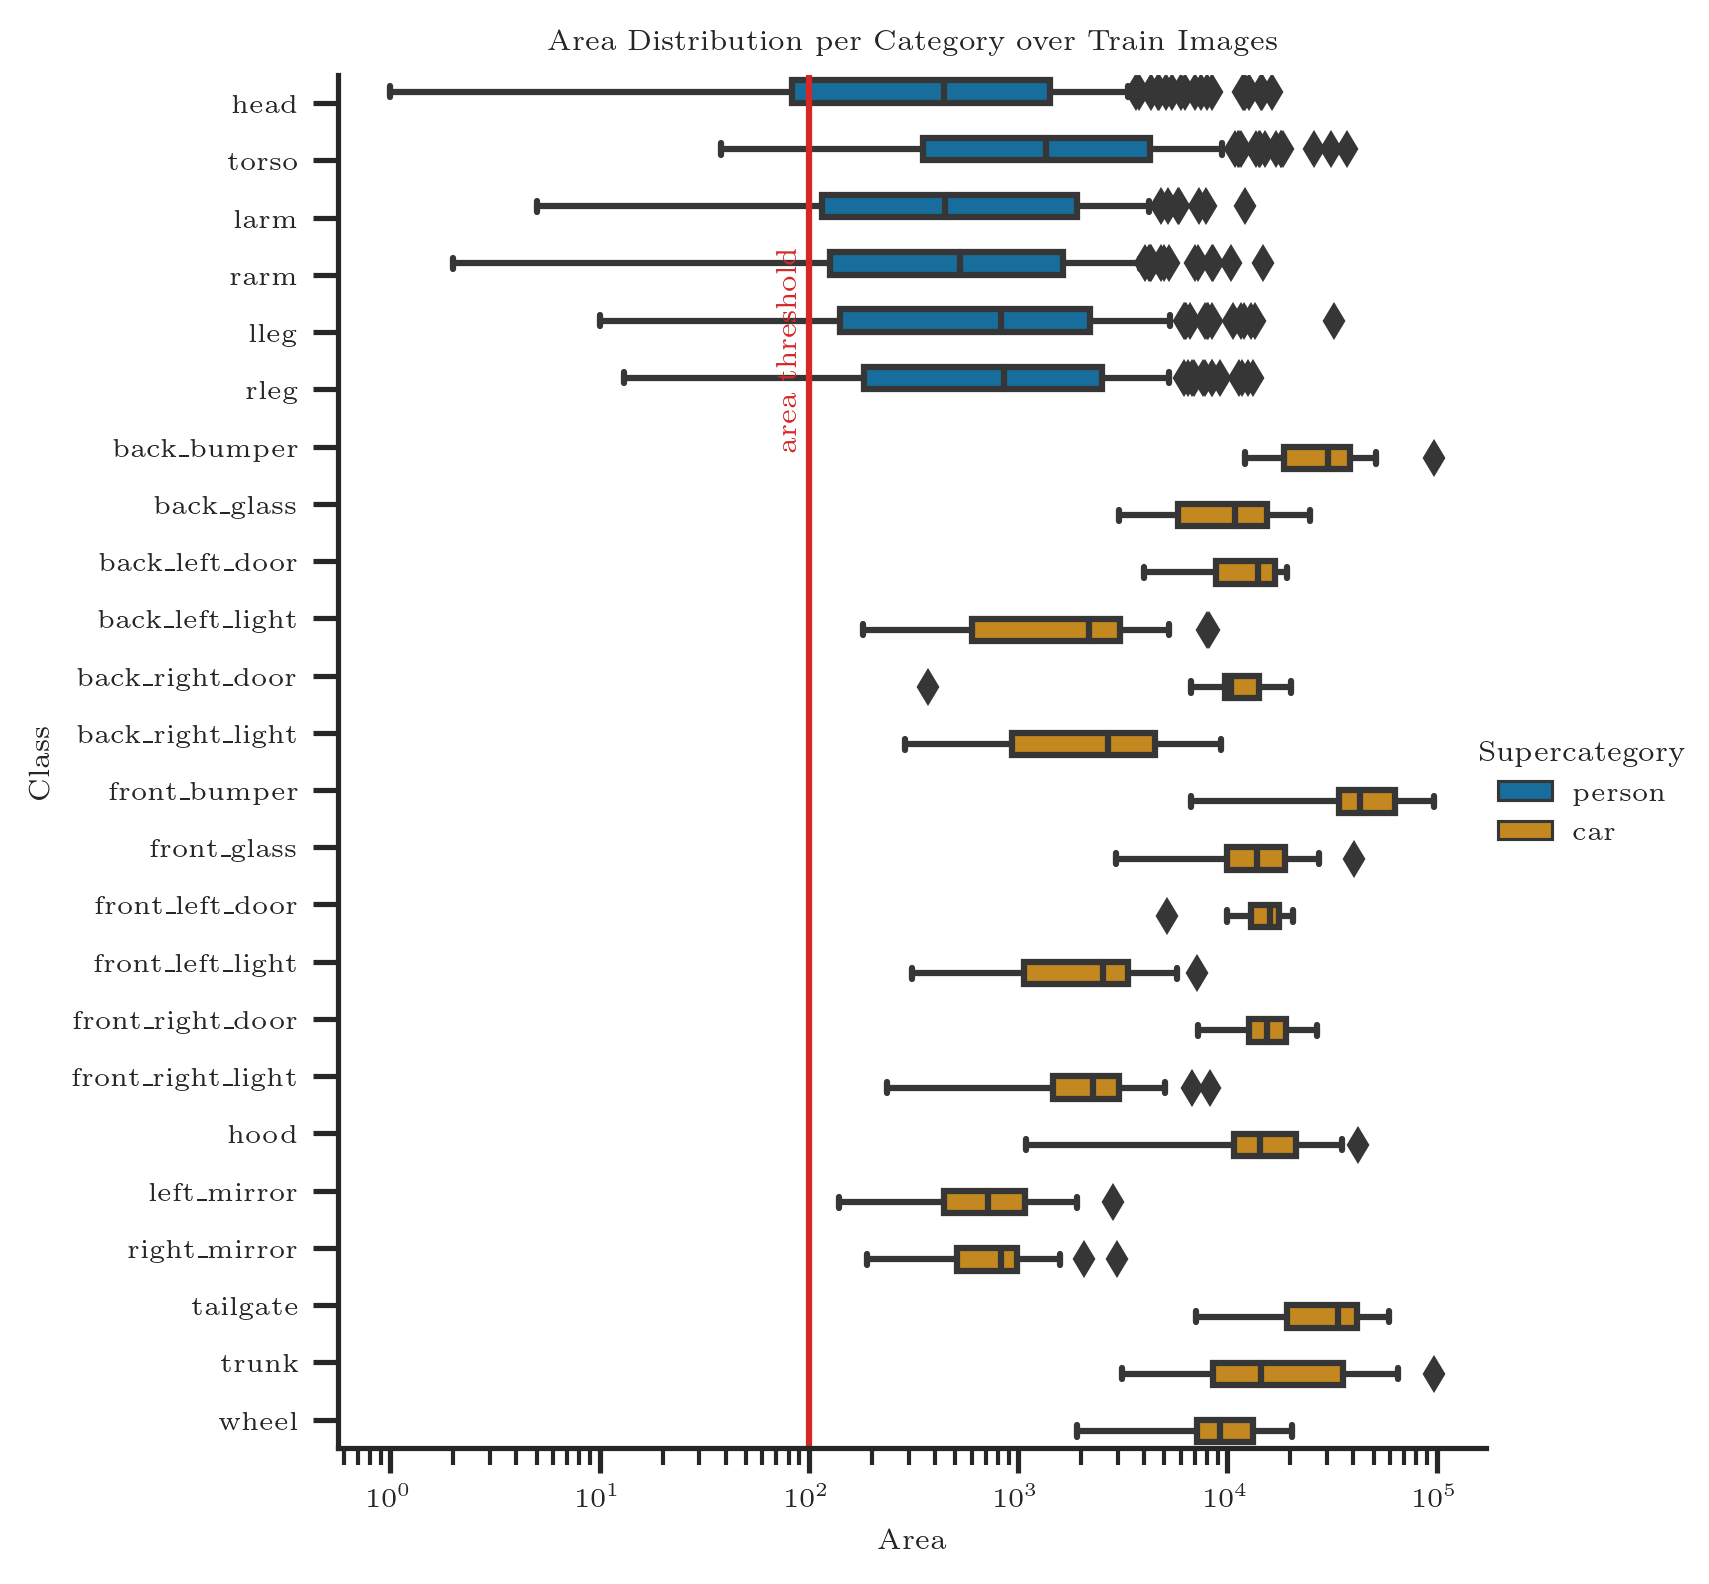

In [63]:
if len(df) > 0:
    to_defaults()

    figwidth = 252 #pt
    fs = 7 #pt
    f = "cm"
    ff = "serif"
    params = get_params("pdf", figwidth, "pt", ar="golden", f=f, fs=fs, ff=ff, show_dpi=300)
    set_style("paper", "ticks", params)
    sns.set_palette("colorblind")

    plt.figure()
    g = sns.catplot(x="area", y="cat", hue="supercat", data=df, kind="box")

    # Add vertical area threshold line
    plt.axvline(x=100, color=colors[3])
    ax = plt.gca()
    ax.text(100-20,6, "area threshold", color=colors[3], ha="center", rotation="vertical")

    g.set(xscale="log")
    g.legend.set_title("Supercategory")
    plt.title("Area Distribution per Category over Train Images")
    plt.xlabel("Area")
    plt.ylabel("Class")
    #plt.xlim([10,1000])
    plt.show()

## Img

In [64]:
# If imgs are equal
if pdset:
    pdf = pd.DataFrame.from_dict(pdset.imgs.values())
    wdf = pd.DataFrame.from_dict(dset.imgs.values())
    print(wdf.equals(pdf))

True

In [65]:
print(f"train/wholes: {len(dset)}")
if pdset:
    print(f"train/parts: {len(pdset)}")

train/wholes: 180

train/parts: 180

################################################################################

imgid: 56

number of anns: 1

################################################################################

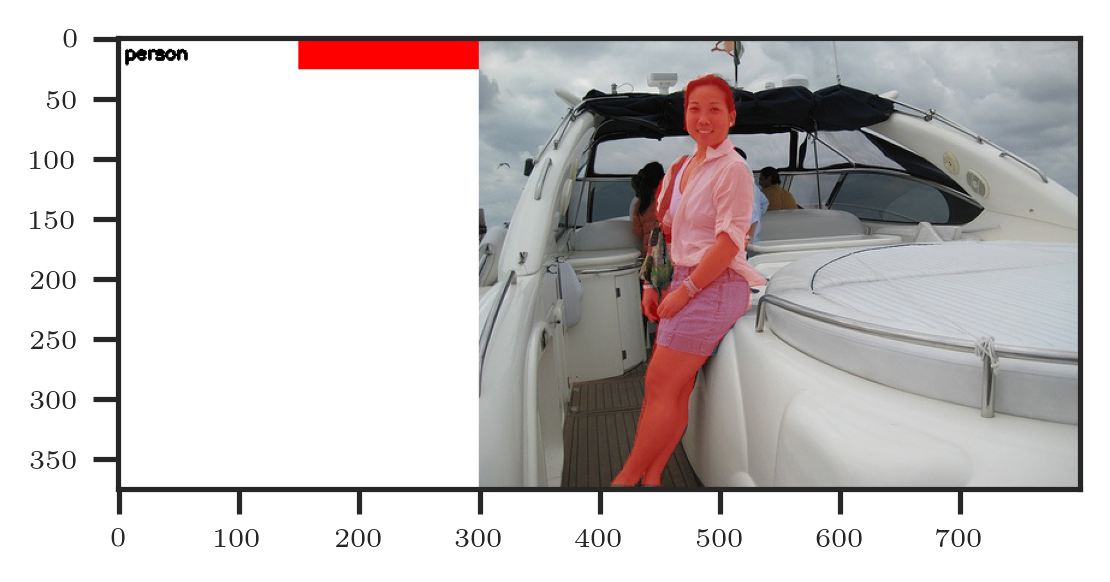

In [67]:
imgid = show_rand_img(dset, "person")

################################################################################

imgid: 56

number of anns: 6

################################################################################

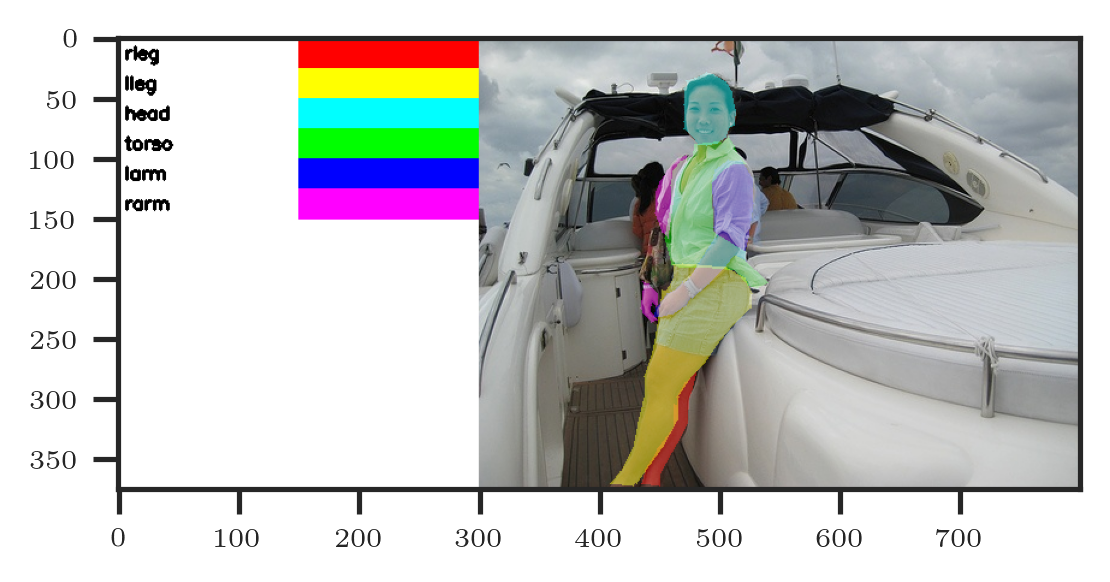

In [68]:
if pdset:
    show_rand_img(pdset, "person", imgid)

In [69]:
if parts_path.exists():
    coco = Parts2WholesDataset(CocoDataset(wholes_path, parts_path))
else:
    coco = Parts2WholesDataset(CocoDataset(wholes_path))

loading annotations into memory...
Loading json: /data/dataset/grmix/orig/annotations/val_wholes.json
Done 0.01s
creating index...
index created!
loading annotations into memory...
Loading json: /data/dataset/grmix/orig/annotations/val_parts.json
Done 0.14s
creating index...
index created!


In [70]:
print(f"cat: {coco.cats[1].keys()}")
print(f"whole ann: {coco.load_anninfos([1], from_gt=True)[0].keys()}")
print(f"part ann: {coco.load_anninfos([1], from_gt=False)[0].keys()}")
print(f"whole img: {coco.load_imginfos([1], from_gt=True)[0].keys()}")
print(f"whole img: {coco.load_imginfos([1], from_gt=False)[0].keys()}")

cat: dict_keys(['id', 'name', 'supercategory', 'is_whole', 'has_parts'])

whole ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 
'iscrowd', 'spawn_id', 'is_occluded', 'occluders'])

part ann: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 
'iscrowd', 'spawn_id', 'is_occluded', 'occluders'])

whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 
'coco_url', 'date_captured', 'image_url', 'dataset'])

whole img: dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 
'coco_url', 'date_captured', 'image_url', 'dataset'])

In [71]:
catids = coco.get_catids(supercats=supercats)
print(catids)

[
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26
]

In [72]:
catids = coco.get_wholecat_ids(supercats)
print(catids)

[1, 8]